In [1]:
import openslide
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import pandas as pd
from scipy.stats import mstats
from functools import reduce
from operator import mul
import os
import glob
%matplotlib inline

from pylab import rcParams
rcParams['figure.figsize'] = 10, 10

/usr/local/lib/python2.7/dist-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
"""
Helper functions.
"""

def closestLevel(levelDims,w):
    differences = map(lambda dim: (abs(dim[1]-w), abs(dim[1]-w)),levelDims)
    areas = map(lambda levelDims: reduce(mul,levelDims),(differences))
    level = [idx for idx,area in enumerate(areas) if area == min(areas)][0]
    return level


def blockshaped(arr, nrows, ncols):
    """
    Return an array of shape (n, nrows, ncols) where
    n * nrows * ncols = arr.size

    If arr is a 2D array, the returned array should look like n subblocks with
    each subblock preserving the "physical" layout of arr.
    """
    h, w = arr.shape
    return (arr.reshape(h/int(nrows), nrows, -1, ncols)
               .swapaxes(1,2)
               .reshape(-1, nrows, ncols))

def pad(arr,windowSize):
    
    """
    Pads array to be divisible by window size.
    """
    
    divisible = False
    while divisible == False:
        if  arr.shape[0] % windowSize != 0:
            arr = np.pad(arr,((0,2),(0,0)),"constant")
        if  arr.shape[1] % windowSize != 0:
            arr = np.pad(arr,((0,0),(0,2)),"constant")

        if all([dim % windowSize ==0 for dim in arr.shape])==True:
                divisible = True
    return arr

def getBoxCoords(blocksPair,level,upscaleLevel):
    
    """
    Returns information to load region of high resolution image. Given indicies blocks for x and y,
    low resolution image level and desired output level.
    """
    x = blocksPair[1]
    x1 = x[0][0] -1 
    x2 = x[0][-1]
    y = blocksPair[0]
    y1 = y[0][0] -1 
    y2 = y[-1][0]
    #print("X",x1,x2)
    #print("Y",y1,y2)
    upscaledX0 = map(lambda coord: np.power(2,level)*coord, (x1,x2)) #Level 0 x coords needed for region initial value
    upscaledY0 = map(lambda coord: np.power(2,level)*coord, (y1,y2)) #Level 1 y coords needed for region initial value
    location = (upscaledX0[0],upscaledY0[0])
    upscaledX = map(lambda coord: np.power(2,level-upscaleLevel)*coord, (x1,x2))
    upscaledY = map(lambda coord: np.power(2,level-upscaleLevel)*coord, (y1,y2))
    size = ((upscaledX[1] - upscaledX[0]),(upscaledY[1] - upscaledY[0]))
    return location, size, ((x1,x2),(y1,y2))

percentage255 = lambda block: np.sum(block==255).astype("float64")/block.size # Calculates percentage of array = 255.

def removeFiles(path):
    """
    Remove all files in a path.
    """
    files = glob.glob(path+"*")
    for f in files:
        os.remove(f)

In [11]:
"""
Main image object.
"""

class her2Image():
    def __init__(self,caseNumber,minNoFactors,threshArea,threshMargin,upscaleWindowSize,upscaleLevel,blackThresh,blurSize):
        
        case = groundTruth.loc[groundTruth.CaseNo==caseNumber]
        self.score, self.percScore = case["HeR2 SCORE"].values[0], case["PERCENTAGE CELLS WITH COMPLETE MEMBRANE STAINING IRRESPECTIVE OF INTENSITY"].values[0]

        self.her2 = openslide.open_slide('data/'+str(caseNumber)+'_HER2.ndpi') # Main image object in wdi format
        #self.he = openslide.open_slide('data/'+str(caseNumber)+'_HE.ndpi')
        self.nLevels = self.her2.level_count # Number of levels
            
        #self.level = closestLevel(self.her2.level_dimensions,1000)
        self.level = 6
        self.lowResDims = self.her2.level_dimensions[self.level] #3 is arbitrary but works
        self.lowResRGB = np.asarray(self.her2.read_region((0,0),self.level,(self.lowResDims[0],self.lowResDims[1]))).copy() 
    
        #Remove black
        black = np.logical_and.reduce((self.lowResRGB[:,:,0] > blackThresh,
                                       self.lowResRGB[:,:,1] > blackThresh,
                                       self.lowResRGB[:,:,2] > blackThresh, 
                                       self.lowResRGB[:,:,3] > blackThresh))
        black4 = np.dstack([black for i in range(3)])
        self.lowResRGB[np.logical_not(black4)] = mstats.mode(self.lowResRGB[:,:,:3],axis=None)[0]
        
        
        self.lowRes = cv2.cvtColor(self.lowResRGB, cv2.COLOR_RGB2GRAY) # Grayscale
        self.lowResArea = reduce(mul,self.lowResDims) # Area of image
        self.mode = mstats.mode(self.lowRes,axis=None)[0]
        
        # Thresholded image
        img = cv2.GaussianBlur(self.lowRes,(blurSize,blurSize),0)
        ret,self.thresh = cv2.threshold(img,mstats.mode(img,axis=None)[0]-threshMargin,255,1)
        
        # Padd lowRes image and thresholded to make factors
        nrows = ncols = upscaleWindowSize/np.power(2,self.level-upscaleLevel)
        self.lowRes, self.thresh = [pad(arr,nrows) for arr in (self.lowRes, self.thresh)]
        
        coordsX,coordsY = np.indices((self.lowRes.shape[0],self.lowRes.shape[1]))
        blocksX,blocksY = blockshaped(coordsX,nrows,ncols),blockshaped(coordsY,nrows,ncols)
        blocksThresh = blockshaped(self.thresh,nrows,ncols)
        blocksLowRes = blockshaped(self.lowRes,nrows,ncols)

        self.relaventCoords = [] # ROIs

        #featureBlocks = np.where(np.any(blocksThresh==255,axis=(1,2)))[0]
        featureBlocks = np.where(np.array([percentage255(block) for block in blocksThresh])>threshArea)[0] # Percentage covered
        for block in featureBlocks:
            self.relaventCoords.append((blocksX[block],blocksY[block]))
        
    def show(self):
        
        plt.imshow(self.lowResRGB)
        plt.title(("Mode = %d, score = %d and percScore = %d." % (self.mode,self.score,self.percScore)))
        plt.show()
        plt.imshow(self.thresh,cmap=cm.gray)
        plt.show()
             
    def regionGen(self,upscaleLevel,colour=False): 
        for i in range(len(self.relaventCoords)):
            location, size, ((x1,x2),(y1,y2)) = getBoxCoords(self.relaventCoords[i],self.level,upscaleLevel)
            if colour==True:
                thickness = 20
            else:
                thickness = 2
            cv2.rectangle(self.lowResRGB, (x1, y1), (x2, y2), (255,0,0), thickness)
            region = np.asarray(eg.her2.read_region((location[0],location[1]),upscaleLevel,(size[0],size[1])))
            yield region
            


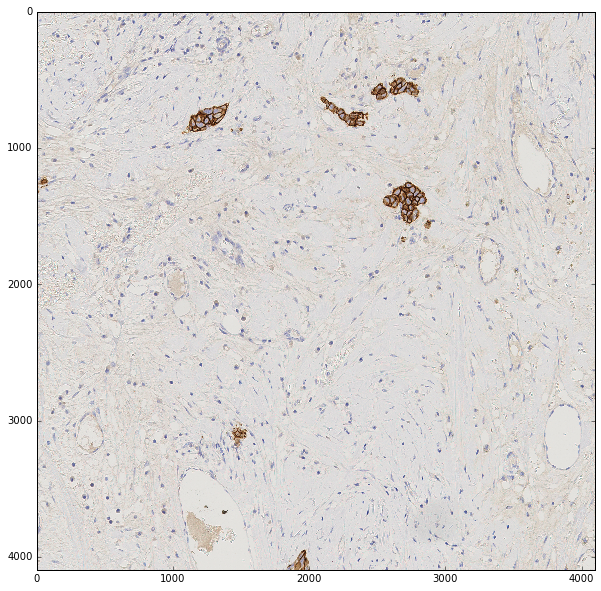

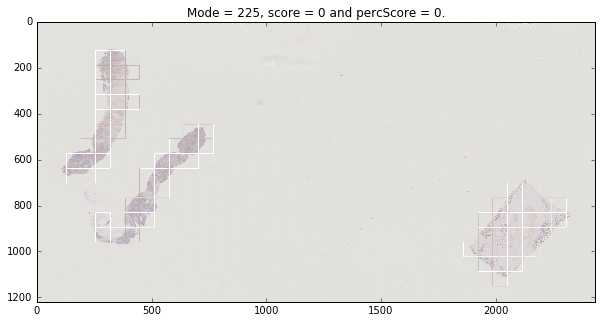

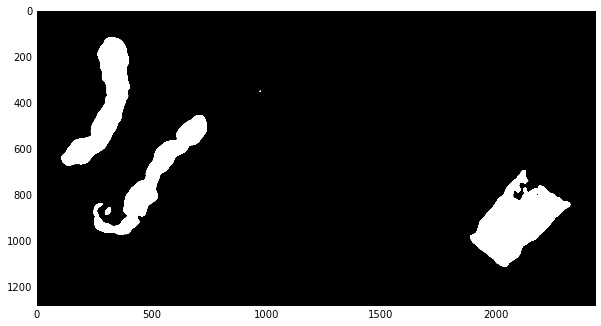

Number of regions generated at level 6 = 68 with dimension 4096 x 4096 x 3.
Image 73 with score of 0, percScore of 0. Region sizes generated 4096.


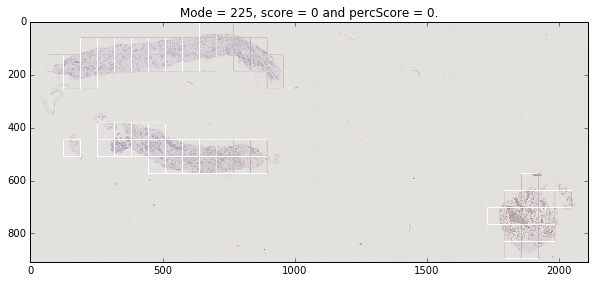

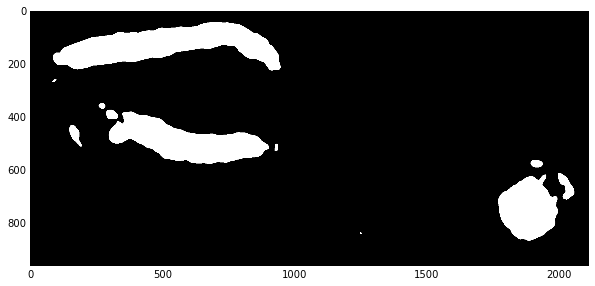

Number of regions generated at level 6 = 65 with dimension 4096 x 4096 x 3.
Image 74 with score of 2, percScore of 10. Region sizes generated 4096.


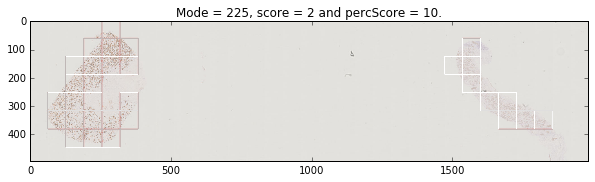

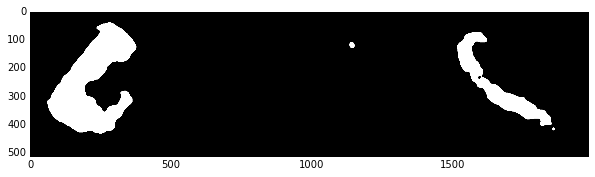

Number of regions generated at level 6 = 31 with dimension 4096 x 4096 x 3.
Image 79 with score of 1, percScore of 5. Region sizes generated 4096.


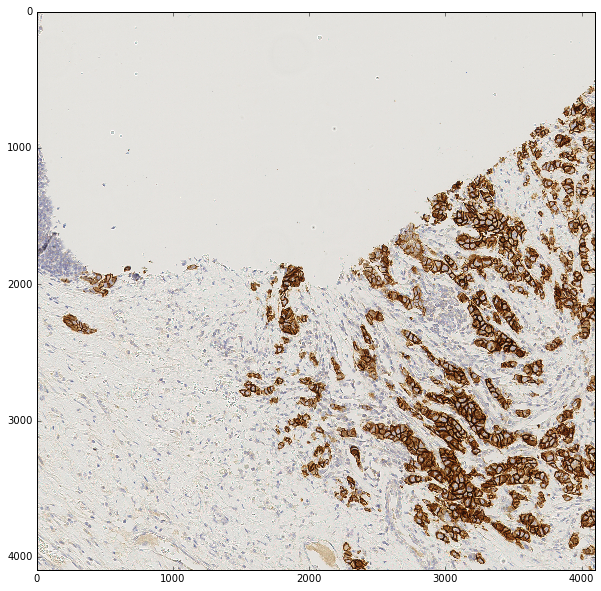

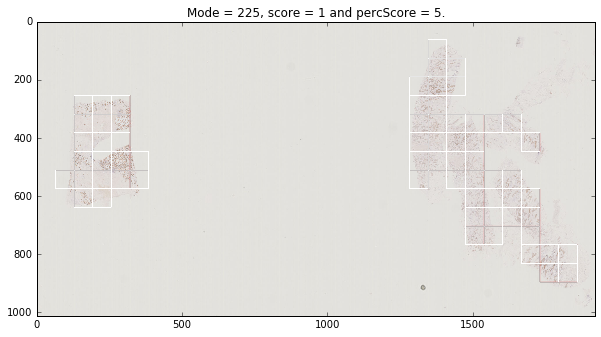

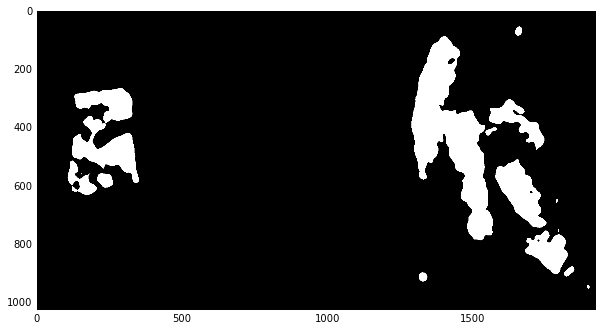

Number of regions generated at level 6 = 63 with dimension 4096 x 4096 x 3.
Image 82 with score of 3, percScore of 80. Region sizes generated 4096.


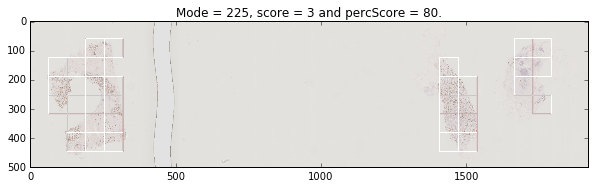

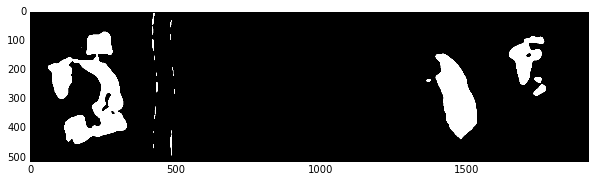

Number of regions generated at level 6 = 33 with dimension 4096 x 4096 x 3.
Image 83 with score of 3, percScore of 100. Region sizes generated 4096.


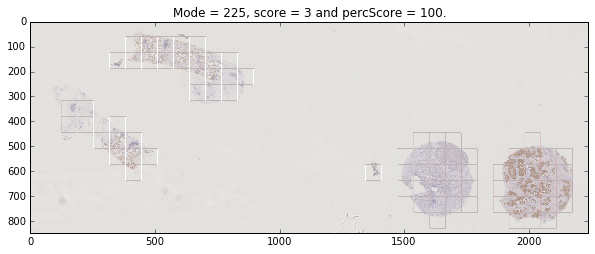

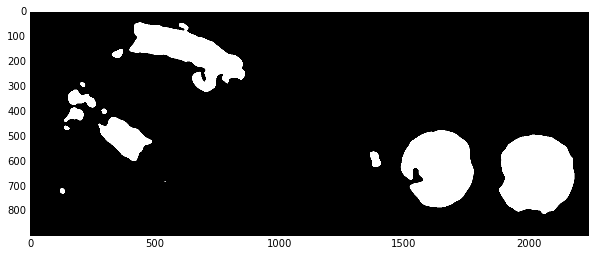

Number of regions generated at level 6 = 79 with dimension 4096 x 4096 x 3.
Image 84 with score of 3, percScore of 70. Region sizes generated 4096.


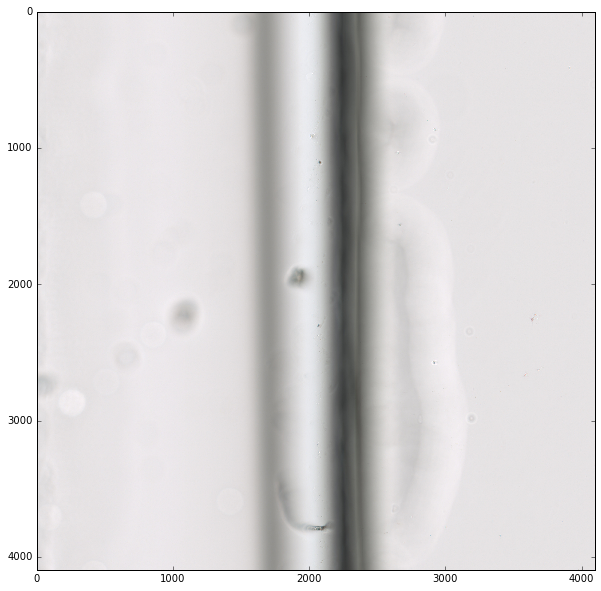

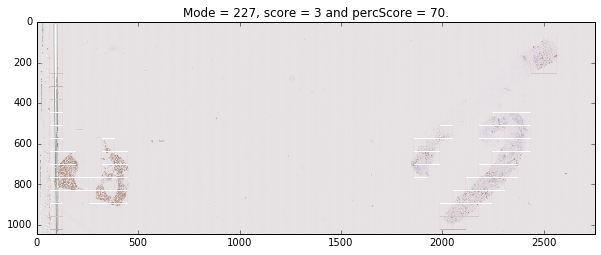

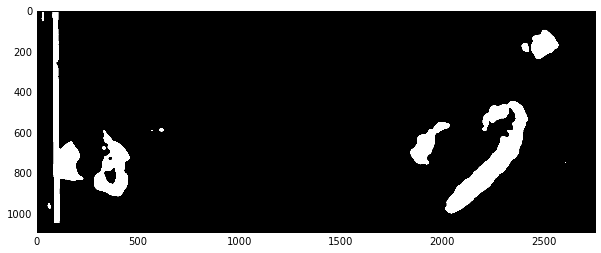

Number of regions generated at level 6 = 68 with dimension 4096 x 4096 x 3.
Image 86 with score of 1, percScore of 3. Region sizes generated 4096.


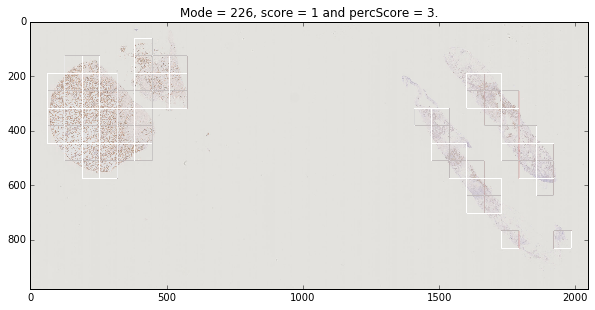

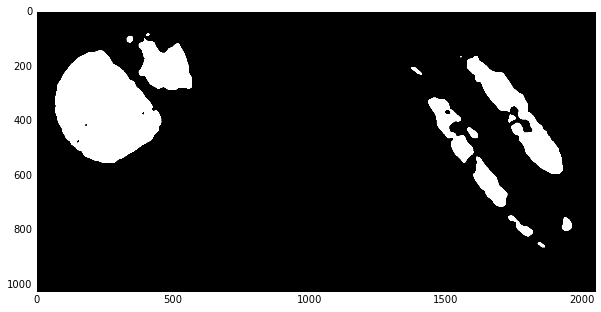

Number of regions generated at level 6 = 68 with dimension 4096 x 4096 x 3.
Image 87 with score of 0, percScore of 0. Region sizes generated 4096.


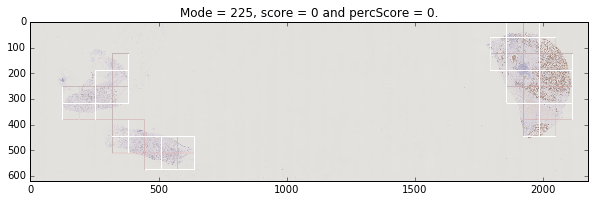

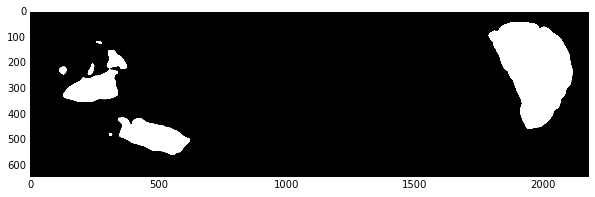

Number of regions generated at level 6 = 44 with dimension 4096 x 4096 x 3.
Image 88 with score of 1, percScore of 5. Region sizes generated 4096.


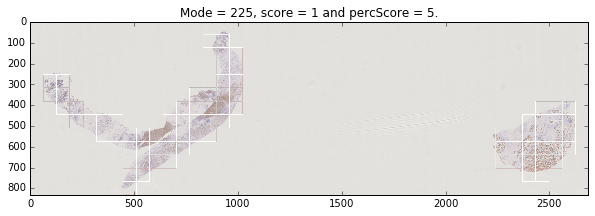

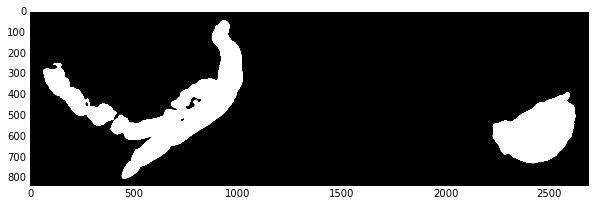

Number of regions generated at level 6 = 78 with dimension 4096 x 4096 x 3.
('Smallest y: ', 4096)
('Smallets x: ', 4096)
('Biggest y: ', 4096)
('Biggest x: ', 4096)
('Number of regions generated: ', [26, 81, 68, 109, 40, 19, 13, 63, 53, 19, 59, 102, 80, 48, 54, 99, 45, 41, 42, 61, 98, 49, 53, 52, 55, 61, 31, 29, 72, 41, 67, 36, 45, 45, 159, 67, 79, 43, 30, 63, 58, 82, 68, 65, 31, 63, 33, 79, 68, 68, 44, 78, 26, 81, 68, 109, 40, 19, 13, 63, 53, 19, 59, 102, 80, 48, 54, 99, 45, 41, 42, 61, 98, 49, 53, 52, 55, 61, 31, 29, 72, 41, 67, 36, 45, 45, 159, 67, 79, 43, 30, 63, 58, 82, 68, 65, 31, 63, 33, 79, 68, 68, 44, 78, 26, 81, 68, 109, 40, 19, 13, 63, 53, 19, 59, 102, 80, 48, 54, 99, 45, 41, 42, 61, 98, 49, 53, 52, 55, 61, 31, 29, 72, 41, 67, 36, 45, 45, 159, 67, 79, 43, 30, 63, 58, 82, 68, 65, 31, 63, 33, 79, 68, 68, 44, 78, 26, 81, 68, 109, 40, 19, 13, 63, 53, 19, 59, 102, 80, 48, 54, 99, 45, 41, 42, 61, 98, 49, 53, 52, 55, 61, 31, 29, 72, 41, 67, 36, 45, 45, 159, 67, 79, 43, 30, 63, 58,

In [114]:
numberOfRegions = []
imagesWithLines = [84,82,35]
if __name__ == "__main__":

    # Hyperparams
    minNoFactors = 10
    threshArea = 0.2
    threshMargin = 8
    
    save = 0
    show = 1
    displayProb = 0.01
    blackThresh = 120
    blurSize = 47

    for upscaleLevel in [4,3,2,1,0]: # For each level
       
        upscaleWindowSize = np.power(2,12-upscaleLevel)
        print("==="*100)
        print("Upscale level %d" %upscaleLevel)
        print("==="*100)

        # Dimensions check
        dims = []

        # CSV
        writePath = "/home/msmith/her2/data/"
        groundTruth = pd.read_csv("data/groundTruth.csv")
        cols = {1: "CaseNo", 2: "HeR2 SCORE",
               3:"PERCENTAGE CELLS WITH COMPLETE MEMBRANE STAINING IRRESPECTIVE OF INTENSITY"}
        #groundTruth.sort_values(by=cols[3],inplace=True)


        # Generate ROIs and saave jpg
        for caseNo in groundTruth.CaseNo.values[:]:
        #for caseNo in imagesWithLines:

            nRegions = 0

            newpath = writePath + "roi_" + str(caseNo) + "/" + str(upscaleLevel) + "/"
            if save == 1:
                removeFiles(newpath)
                if not os.path.exists(newpath):
                    os.makedirs(newpath)

            eg = her2Image(caseNo,minNoFactors,threshArea,threshMargin,upscaleWindowSize,upscaleLevel,blackThresh,blurSize)
            print("==="*100)
            print("==="*100)
            print("Image %d with score of %d, percScore of %d. Region sizes generated %d." % (caseNo,eg.score,eg.percScore,upscaleWindowSize))
            regions = eg.regionGen(upscaleLevel) # region object
            regionNo = 0
            caseDims = [] 
            for region in regions:
                nRegions += 1
                if np.random.uniform() < displayProb and show == 1:
                    plt.imshow(region)
                    plt.show()
                if save == 1:
                    region = region[:,:,:3] # remove alpha
                    region = region[:,:,::-1] # swap rgb
                    cv2.imwrite(newpath + str(regionNo) + ".jpg",region)
                regionNo += 1
                caseDims.append(region.shape)
                #print("All alpha values == 255? %r" % np.all(region[:,:,3]==255))

            dims.append(caseDims)
            eg.show()
            numberOfRegions.append(nRegions)
            print("Number of regions generated at level %d = %d with dimension %d x %d x 3." % (eg.level,nRegions,caseDims[0][0],caseDims[0][1]))

    print("Smallest y: ", min([x[0][0] for x in dims]))
    print("Smallets x: ", min([x[0][1] for x in dims]))

    print("Biggest y: ", max([x[0][0] for x in dims]))
    print("Biggest x: ", max([x[0][1] for x in dims]))

    print("Number of regions generated: ",numberOfRegions)

# For report/paper

In [6]:
minNoFactors = 10
threshArea = 0.2
threshMargin = 8
blackThresh = 120
blurSize = 47
writePath = "/home/msmith/her2/data/imgsForReport/"
groundTruth = pd.read_csv("data/groundTruth.csv")
save = 0
show = 0

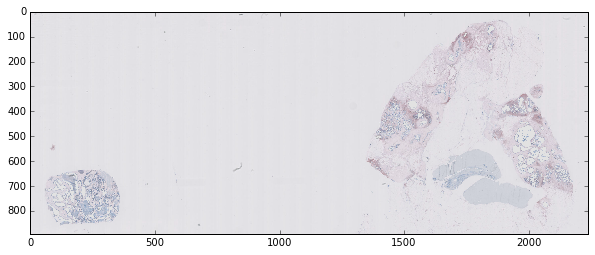

In [12]:
for upscaleLevel in [4,3,2,1,0][-1:]:
    upscaleWindowSize = np.power(2,12-upscaleLevel)
    eg = her2Image(9,minNoFactors,threshArea,threshMargin,upscaleWindowSize,upscaleLevel,blackThresh,blurSize)
    regions = eg.regionGen(upscaleLevel) # region object

    if 0:
        self = eg
        for i in range(len(self.relaventCoords))[:]:
            location, size, ((x1,x2),(y1,y2)) = getBoxCoords(self.relaventCoords[i],self.level,upscaleLevel)
            cv2.rectangle(self.lowResRGB, (x1, y1), (x2, y2), (255,0,0), 3)
        region = np.asarray(eg.her2.read_region((location[0],location[1]),upscaleLevel,(size[0],size[1])))
    #        if regionNo == 30:
        if  show == 1:
            plt.imshow(region)
            plt.show() 
        if save == 1:
            region = region[:,:,:3] # remove alpha
            region = region[:,:,::-1] # swap rgb
            cv2.imwrite(writePath + str(upscaleLevel) + ".jpg",region)

        regionNo += 1


img= cv2.cvtColor(eg.lowResRGB, cv2.COLOR_RGBA2BGR)
#img = img[:,:,::-1]
cv2.imwrite(writePath + "none.jpg",img)
plt.imshow(img)
plt.show()